## Context: Music Discovery and Personalization by echonest
Streaming music is now mainstream, fans have unprecedented music access, making personalizedd music discovery more important than ever. The world’s leading digital music services rely on creating unique taste profiles for their users in order to make playlists more personal, recommendations more relevant, and discovery more social.

However, the current recommendation systems that's based off of listeners who listen to similar artists is only effective for major artists with an extensive fan following and largely miscategorizes new creators. Incorportating a new Recommendation System based off of similar audio proterties, rather than the listeners, in order to cluster similar styles together can help compensate for this discrepancy.


## Goal: Help new customers acquire more loyal music fans by delivering unique, predictive music discovery experiences.

**Personal Playlisting**
- predictive playlists that get smarter over time with machine learning and end-user tuning
- predictive playlisting that adjusts acoustically to each fan’s taste and context
- digital understanding of each individual’s personal music taste -> captures live playback behavior (artist plays, song plays, seeds, skips, bans, favorites, and more) and uses it to personalize playlists, radio, and the rest of the discovery experience.

## Acknowledgements
This work is a simplification from the Kaggle dataset posted at https://www.kaggle.com/grasslover/spotify-music-genre-list#songDb.tsv and the work of The Echo Nest at http://the.echonest.com/.

In [1]:
# Import the relevant python libraries for the analysis
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl

# Access Directory Structure
import os

# Machine Learning
from sklearn.model_selection import train_test_split
import time 
from sklearn.externals import joblib

# Ploting Decision Boundaries
from matplotlib.colors import ListedColormap

# Scaling
from sklearn.preprocessing import StandardScaler

# Recommending System
%run Recommenders.ipynb
import networkx as nx

### Workflow for Using Machine Learning in Predictive Modeling:
**1. Preprocessing**
    - Labels / Raw Data
    - Training Dataset / Test Dataset
**2. Learning**
    - Learning Algorithm
        - Model Selection
        - Cross-Validation
        - Performance Metrics
        - Hyperparameter Optimization
**3. Evaluation** 
    - Final Model
    - Labels Prediction Accuracy
**4. Prediction**
    - New Data
    - Label Predictions

## Creating a Personalized Recommendation System

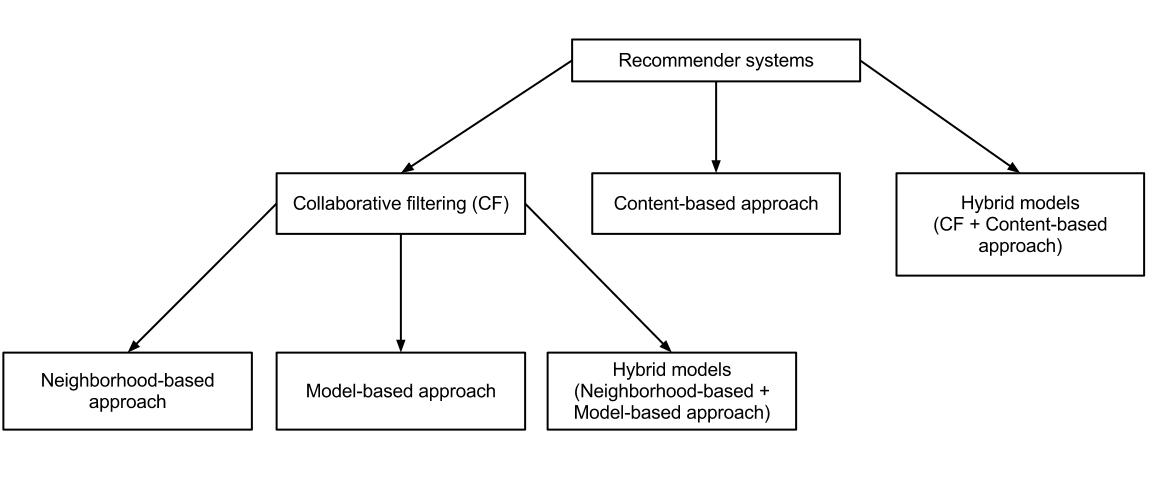

In [5]:
from IPython.display import Image
Image(filename='RecommendationSystems.jpg')

## Section 1: Preprocessing

#### Exploratory Analysis¶
- Load and Clean SongDb.tsv dataset
- Visualize Data

#### Load SongDb.tsv file

In [2]:
# Load SongDb.tsv dataset - convert .tsv file to .csv for uploading
file_encoding = 'utf8'
input_fd = open('data/songDb.tsv', encoding=file_encoding, errors='backslashreplace')
beats = pd.read_csv(input_fd, delimiter='\t', low_memory=False)
beats.head()

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Type,ID,Uri,Ref_Track,URL_features,Duration_ms,time_signature,Genre
0,YuveYuveYu,0.624,0.857,10.0,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926,audio_features,6J2VvzKwWc2f0JP5RQVZjq,spotify:track:6J2VvzKwWc2f0JP5RQVZjq,https://api.spotify.com/v1/tracks/6J2VvzKwWc2f...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal
1,Gloryhammer,0.517,0.916,0.0,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996,audio_features,4HA34COgxgVJ6zK88UN4Ik,spotify:track:4HA34COgxgVJ6zK88UN4Ik,https://api.spotify.com/v1/tracks/4HA34COgxgVJ...,https://api.spotify.com/v1/audio-analysis/4HA3...,300320.0,4.0,celticmetal
2,Nostos,0.251,0.894,8.0,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223,audio_features,3W6Xik6Xxf06JuUoZSATlD,spotify:track:3W6Xik6Xxf06JuUoZSATlD,https://api.spotify.com/v1/tracks/3W6Xik6Xxf06...,https://api.spotify.com/v1/audio-analysis/3W6X...,175353.0,4.0,celticmetal
3,Yggdrasil,0.469,0.743,1.0,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953,audio_features,2gGveBaLJQMtJ43X4UL5kH,spotify:track:2gGveBaLJQMtJ43X4UL5kH,https://api.spotify.com/v1/tracks/2gGveBaLJQMt...,https://api.spotify.com/v1/audio-analysis/2gGv...,272292.0,4.0,celticmetal
4,Incense&Iron,0.487,0.952,1.0,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993,audio_features,1lRF81A1C9QoCgBcEop2zg,spotify:track:1lRF81A1C9QoCgBcEop2zg,https://api.spotify.com/v1/tracks/1lRF81A1C9Qo...,https://api.spotify.com/v1/audio-analysis/1lRF...,237933.0,4.0,celticmetal


In [4]:
print(len(beats.columns)), len(beats.Genre.unique()), len(beats)

20


(None, 626, 131580)

In [3]:
print(beats.columns)

Index(['Name', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
       'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
       'Tempo', 'Type', 'ID', 'Uri', 'Ref_Track', 'URL_features',
       'Duration_ms', 'time_signature', 'Genre'],
      dtype='object')


#### Assess Data Cleanliness and Drop all rows with NaN values

In [6]:
beats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131580 entries, 0 to 131579
Data columns (total 20 columns):
Name                131578 non-null object
Danceability        131580 non-null float64
Energy              131580 non-null float64
Key                 131580 non-null float64
Loudness            131580 non-null float64
Mode                131580 non-null float64
Speechness          131580 non-null float64
Acousticness        131580 non-null float64
Instrumentalness    131580 non-null float64
Liveness            131580 non-null float64
Valence             131580 non-null float64
Tempo               131580 non-null object
Type                131580 non-null object
ID                  131580 non-null object
Uri                 131580 non-null object
Ref_Track           131580 non-null object
URL_features        131580 non-null object
Duration_ms         131580 non-null float64
time_signature      131580 non-null object
Genre               131554 non-null object
dtypes: float64(11

In [7]:
beats = beats.dropna()

In [8]:
print(len(beats.columns)), len(beats.Genre.unique()), len(beats)

20


(None, 625, 131552)

#### Visualize Data
- Use a Scatterplot Matrix to visualize pair-wise correlations between different features in the dataset in one place

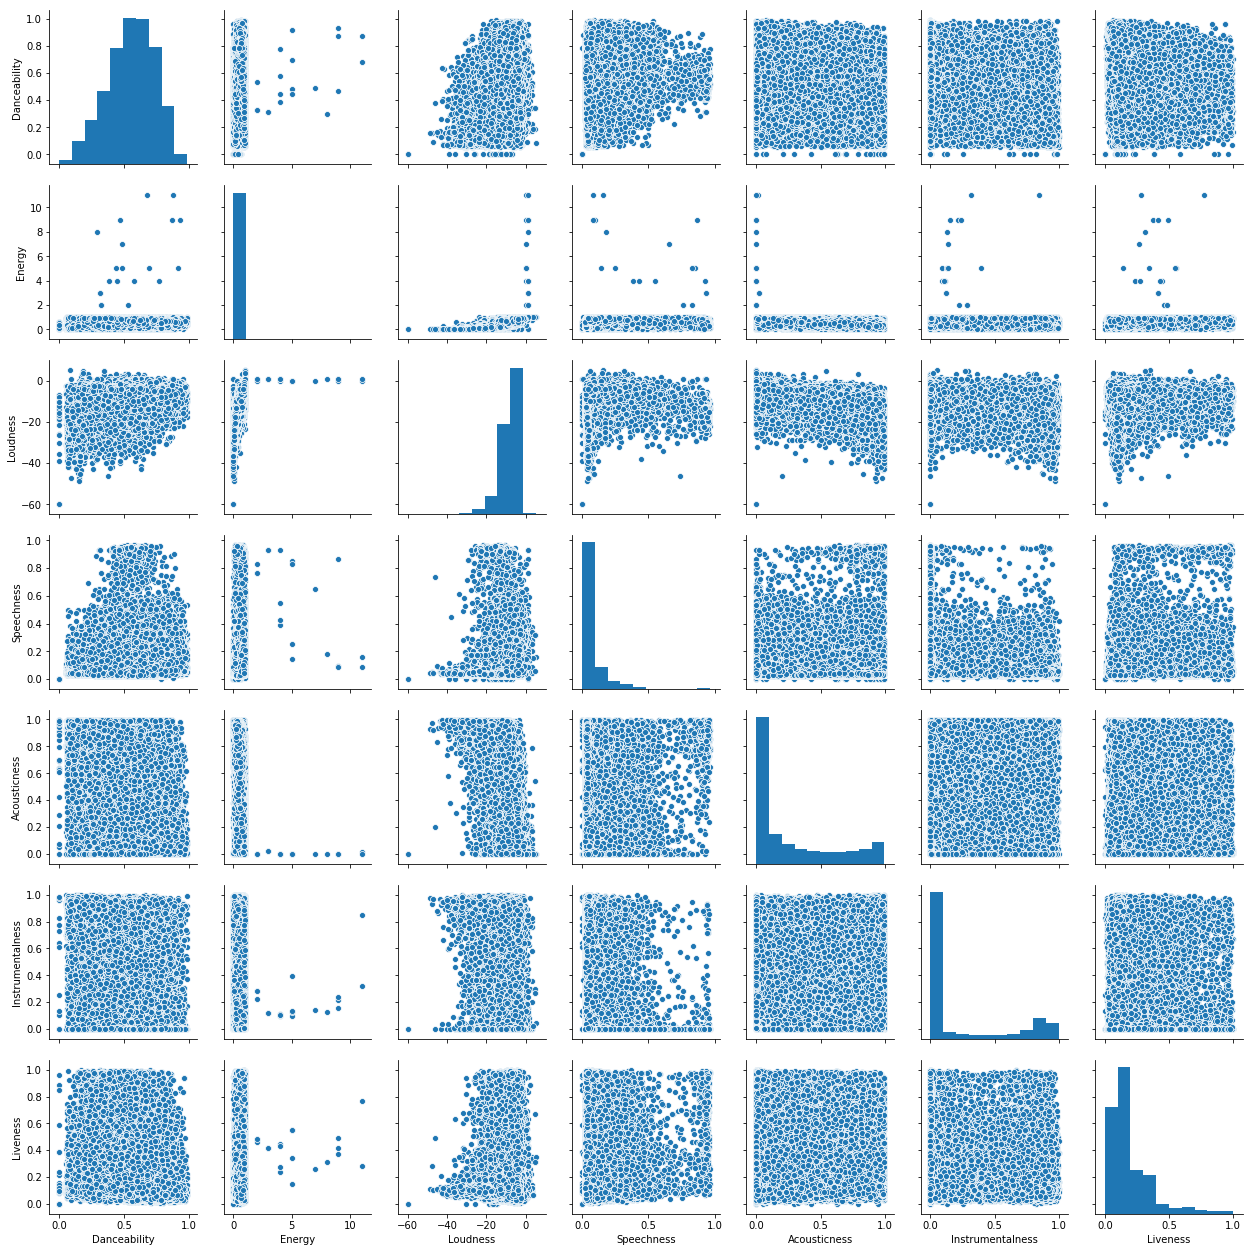

In [7]:
# create a figure and axis
cols = ['Name', 'Danceability', 'Energy', 'Loudness',
       'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Tempo', 'Genre']

sns.pairplot(beats[cols])
plt.show()

#### Assessing Correlation of Co-Efficients

In [11]:
cm = np.corrcoef(beats[cols])
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

TypeError: can only concatenate str (not "float") to str

#### Training and Testing Data

In [8]:
train_data, test_data = train_test_split(beats, test_size = 0.20, random_state=0)
train_data.head(5)

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Type,ID,Uri,Ref_Track,URL_features,Duration_ms,time_signature,Genre
131036,OmMantra,0.238,0.355,2.0,-16.485,0.0,0.0368,0.967000,0.853,0.1030,0.0556,92.593,audio_features,3lSRMSkO5kSKrtst3OJ29L,spotify:track:3lSRMSkO5kSKrtst3OJ29L,https://api.spotify.com/v1/tracks/3lSRMSkO5kSK...,https://api.spotify.com/v1/audio-analysis/3lSR...,219628.0,4.0,meditation
78741,LastSunriseInTheWasteland,0.452,0.342,0.0,-7.451,1.0,0.0326,0.008560,0.857,0.2670,0.0463,125.986,audio_features,3lBPp5qjEjDRFjFV2beh35,spotify:track:3lBPp5qjEjDRFjFV2beh35,https://api.spotify.com/v1/tracks/3lBPp5qjEjDR...,https://api.spotify.com/v1/audio-analysis/3lBP...,169250.0,4.0,focus
47053,ShakeTheSilence,0.605,0.955,10.0,-8.473,0.0,0.1120,0.013300,0.804,0.3970,0.0374,138.02,audio_features,0Ef9QaUocmO361bQoEwn4V,spotify:track:0Ef9QaUocmO361bQoEwn4V,https://api.spotify.com/v1/tracks/0Ef9QaUocmO3...,https://api.spotify.com/v1/audio-analysis/0Ef9...,377995.0,4.0,psychedelictrance
50567,Nihilist(feat.ThunderScott),0.299,0.896,10.0,-9.489,1.0,0.1610,0.000013,0.845,0.0883,0.1440,119.902,audio_features,0YD7pECswvkxsOzzM1ket0,spotify:track:0YD7pECswvkxsOzzM1ket0,https://api.spotify.com/v1/tracks/0YD7pECswvkx...,https://api.spotify.com/v1/audio-analysis/0YD7...,202646.0,4.0,metalguitar
36526,TakeIt(feat.KarianSang)-Raw,0.513,0.798,0.0,-5.351,0.0,0.4460,0.241000,0.000,0.1350,0.5860,111.478,audio_features,1Q5nGrPq4O8ybrzHsDxd7F,spotify:track:1Q5nGrPq4O8ybrzHsDxd7F,https://api.spotify.com/v1/tracks/1Q5nGrPq4O8y...,https://api.spotify.com/v1/audio-analysis/1Q5n...,185687.0,5.0,reggaerock


## Part 2: Learning
- Model Selection
    - Cross-Validation
    - Performance Metrics
    - Hyperparameter Optimization

#### Predicting

#### Create a Class for Song Similarity

#### Recommendation

#### Decision Regions
- Motification of original source code from p. 32 of the 'Python Machine Learning' textbook by Sebastian Raschaka & Vahid Mirjalili 

In [ ]:
def plot_decision_regions(X, y, classifier, resolution=0.2):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.mexhgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array[xx1.rave1(), xx2.ravel()].T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0],
                    y=Y[ y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=c1,
                    edgecolor='black')